In [1]:
import osmnx as ox

ox.config(log_console = True, data_folder = 'data')
a = 'northeuroperails_alt.graphml'
graph = ox.load_graphml(a)

In [2]:
import networkx as nx

hki = ox.truncate_graph_bbox(graph, 60.308, 60.151, 25.243, 24.704, retain_all=True)
hki = hki.to_undirected()

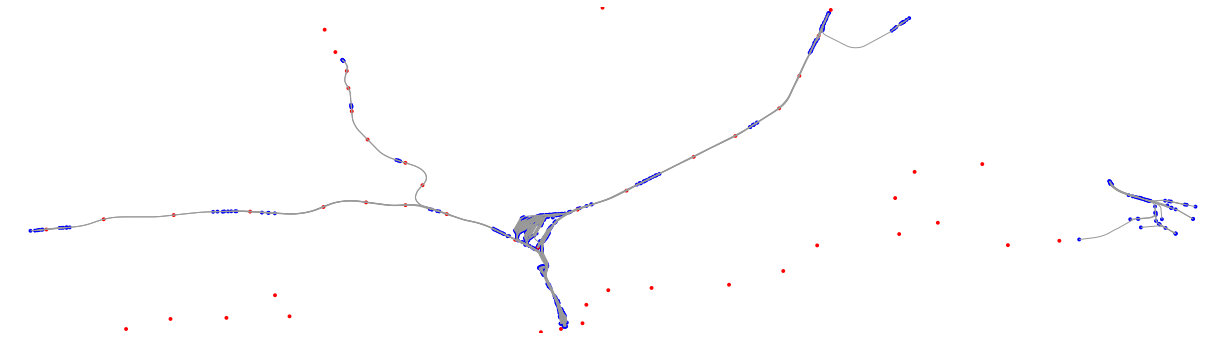

(<Figure size 1563.34x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fae74df9760>)

In [3]:
node_colors = ['r' if 'railway' in d and d['railway'] == 'station' else 'b' for d in hki.nodes.values()]
ox.plot_graph(hki, node_color = node_colors)

In [1]:
import numpy as np
import pandas as pd
try:
    from sklearn.neighbors import BallTree
except ImportError as e:
    BallTree = None

# This method is modified get_nearest_edges method from osmnx (https://github.com/gboeing/osmnx)
def get_nearest_edges(G, X, Y, k=100, dist=0.0001, max_distance=0.000005):
    # transform graph into DataFrame
    edges = ox.graph_to_gdfs(G, nodes=False, fill_edge_geometry=True)

    # transform edges into evenly spaced points
    edges['points'] = edges.apply(lambda x: ox.redistribute_vertices(x.geometry, dist), axis=1)

    # develop edges data for each created points
    extended = edges['points'].apply([pd.Series]).stack().reset_index(level=1, drop=True).join(edges).reset_index()

    # haversine requires data in form of [lat, lng] and inputs/outputs in units of radians
    nodes = pd.DataFrame({'x': extended['Series'].apply(lambda x: x.x),
                            'y': extended['Series'].apply(lambda x: x.y)})
    nodes_rad = np.deg2rad(nodes[['y', 'x']].values.astype(np.float))
    points = np.array([Y, X]).T
    points_rad = np.deg2rad(points)

    # build a ball tree for haversine nearest node search
    tree = BallTree(nodes_rad, metric='haversine')

    # query the tree for nearest node to each point
    all_nearest_edges = []
    idx = tree.query(points_rad, k, return_distance=True)

    # Map the results and filter according to max distance
    for i in range(len(idx[1])):
        current_node_nearest_edges = []
        for j in range(len(idx[0][i])):
            if idx[0][i][j] < max_distance:
                current_node_nearest_edges.append(idx[1][i][j])
        eidx = extended.loc[current_node_nearest_edges, 'index']
        ne = edges.loc[eidx, ['u', 'v']]
        all_nearest_edges.append(np.array(ne))

    return results

stations = np.array(
    [[k, v['x'], v['y']] for k, v in hki.nodes.items() if 'railway' in v and v['railway'] == 'station']
)
nearest = get_nearest_edges(hki, stations[:, 1], stations[:, 2])
print(nearest)

NameError: name 'hki' is not defined